#最终采用单个时间点来做预测
#上交的代码将读入data/15_sample_data.csv文件,由于其只包含15000个点,所以训练结果仅用作示范,没有实际意义

In [1]:
from __future__ import unicode_literals
import os
import warnings
from numpy import newaxis
import pandas as pd
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Activation
from keras.layers import Convolution2D, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import Callback
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import h5py


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

def conv2flag(number):
    if number == 133:
        return 1
    elif number == 132:
        return 1
    else:
        return 0

def conv2Nonelabel(number):
    if number == 1:
        return 1
    elif number == 2:
        return 0
    else:
        return np.nan

def conv2Noneflag(number):
    if number == 0:
        return np.nan
    else:
        return 1

def convert_dataset(x_data, y_data, look_back=60, sweep = 1):
    dataX, dataY = [], []
    for i in range(0,len(x_data)-look_back-1,sweep):
        a = x_data[i:(i+look_back)]
        dataX.append(a)
        dataY.append(y_data[i + look_back - 1])
    return np.array(dataX), np.array(dataY)

def drop_nan(dataX, dataY):
    dataX_new = []
    dataY_new = []
    for i in range(dataX.shape[0]):
        if str(dataY[i]) == 'nan':
            continue
        else:
            nan_flag = 0
            for j in range(dataX.shape[1]):
                for k in range(dataX.shape[2]):
                    if str(dataX[i,j,k]) == 'nan':
                        nan_flag = 1
                        break
                if nan_flag == 1:
                    break
            if nan_flag == 0:
                dataX_new.append(dataX[i])
                dataY_new.append(dataY[i])
    return np.array(dataX_new), np.array(dataY_new)

def get_dataFrame(num):
    #从本地的data文件夹读取训练数据
    df1=pd.read_csv('data/'+num+'_data.csv',sep=',') 
#     df2=pd.read_csv('data/'+num+'data-weather.csv',sep=',',header=None) 
#     df2.columns = ['temperature','relative_humidity','pressure']
#     df =pd.concat([df1,df2], axis = 1) 
    df = df1
    
    df['wtur_flt_main'] = df['wtur_flt_main'].diff()
    df['wtur_flt_main'] = df['wtur_flt_main'].map(conv2flag)
    df['wman_state'] = df['wman_state'].map(conv2Noneflag)
    qr = df.query('wtur_flt_main == 1')
    x_old = 1
    for x in qr.index :
        if (x - x_old) > 6000:
            #1 for fault surely;2 for health surely; 0 (default) for unsure
            df['wtur_flt_main'][(x-1000):x] = 1
            df['wtur_flt_main'][(x-6000):(x-4000)] = 2 #-12h to -8h is sure for health
        else:
            df['wtur_flt_main'][(x-1000):x] = 1 #1000 is for 2 hours (1.94h);        
        x_old = x
    df['wtur_flt_main'] = df['wtur_flt_main'].map(conv2Nonelabel)    
    return df

#获取温度差
def add_delta_tmp(df, delta):
    # delta = 6000: 12h
    col = 'tmp_%s'%(delta,)
    if col not in df.columns:
        df.insert(df.shape[1], col ,1)
    df[col] = df["environment_tmp"].diff(delta)
    return df

# get_data 与 get_data_sub为研究特征选取时所用的函数.
def get_data(df):
    # v0:包含全部原始的特征值，没有包含天气数据，测试准确率约为80%
    look_back = 60
    sweep= 2
    df_sel = df.drop(["time", "wtid", 'temperature','relative_humidity',
                        'pressure','wman_state','wtur_flt_main'], 1) 
    
    # v1:仅仅包含由人工选取出来的特征值，包含天气数据，取一个时间段,测试准确率约为70%
#     look_back = 60
#     sweep= 2
#     df_sel = df.loc[:,["wind_speed",
#             "generator_speed","power","wind_direction_mean",
#                 "yaw_position","pitch1_angle","pitch2_angle",
#                        "pitch3_angle",                
#                 "environment_tmp","int_tmp",
#                 'temperature','relative_humidity','pressure']]
    
    #输入新数据进行预测时,应该首先对输入数据按照原来的标准进行归一化
    column_min = {}
    column_max = {}
    for i in range(df_sel.shape[1]):
        column_min[list(df_sel)[i]] = np.min(df_sel.iloc[:,i])
        column_max[list(df_sel)[i]] = np.max(df_sel.iloc[:,i])
        
    norm_df = df_sel.iloc[:,:].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    norm_df['wman_state'] = df['wman_state']
    
    x_data = norm_df.iloc[:,0:norm_df.shape[1]].values
    y_data = df.loc[:,'wtur_flt_main'].values # 'wtur_flt_main' 不可加方括号

    dataX, dataY = convert_dataset(x_data, y_data, look_back, sweep)
    dataX_new, dataY_new = drop_nan(dataX, dataY)
    dataX_new = dataX_new[:,:,0:-1]
    dataY_new = np_utils.to_categorical(dataY_new)
    
    end = dataX_new.shape[0]
    # end = 2000
    spl = 0.7
    X_train = dataX_new[0:int(end*spl)]
    y_train = dataY_new[0:int(end*spl)]
    X_test = dataX_new[int(end*spl):int(end*1)]
    y_test = dataY_new[int(end*spl):int(end*1)]
    print("=== get_data_v0 ===")
    print("dimensions of traing data and test data are:")
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    return [column_min, column_max, X_train, y_train, X_test, y_test]
    
#另一类获取训练数据的方式
# 先对df进行dropnan处理，再进行时间段切割，理论上来说这样做不够严谨，因为会造成
# 原本在时间上没有连在一起的数据连在一起, 但在look-back = 1时这个问题不存在.
def get_data_sub(df):
#     v0包含全部原始的特征值，没有包含天气数据
    look_back = 1
    sweep= 1
    df = add_delta_tmp(df, 3000)
#     df = add_delta_tmp(df, 3000)
#     df = add_delta_tmp(df, 1500)
    
    df_sel = df.dropna()
    y_data = df_sel.loc[:,'wtur_flt_main'].values # 'wtur_flt_main' 不可加方括号
#     df_sel = df_sel.drop(["time", "wtid", 'temperature','relative_humidity'
#                           ,'pressure','wman_state','wtur_flt_main'], 1)

#     df_sel = df_sel.drop(["time", "wtid", 'temperature','wman_state','wtur_flt_main'], 1)
    
#     df_sel = df_sel.loc[:,["wind_speed",
#             "generator_speed","power","wind_direction",
#             "wind_direction_mean",
#             "yaw_position","yaw_speed",
#             "pitch1_angle","pitch2_angle","pitch3_angle", 
#             "pitch1_speed","pitch2_speed","pitch3_speed",
#             "acc_x","acc_y",
#             "environment_tmp","int_tmp",
#             'relative_humidity']]
    
#     df_sel = df_sel.loc[:,["wind_speed",
#         "generator_speed","power","wind_direction_mean",
#             "yaw_position","pitch1_angle","pitch2_angle",
#                    "pitch3_angle",                
#             "environment_tmp","int_tmp",'relative_humidity','pressure']]
#     df_sel = df.loc[:,["wind_speed",
#     "power","wind_direction_mean",
#         "yaw_position","pitch1_angle","pitch2_angle",
#                "pitch3_angle",                
#         "environment_tmp",'relative_humidity','pressure']]

#     df_sel = df_sel.loc[:,["wind_speed",
#             "generator_speed","power","wind_direction",
#             "wind_direction_mean",
#             "yaw_position",
#             "pitch1_angle","pitch2_angle","pitch3_angle", 
#             "acc_x","acc_y",
#             "environment_tmp","int_tmp"
#             ]]

#最终的特征选取方案
    df_sel = df_sel.loc[:,["wind_speed",
        "generator_speed","power","wind_direction",
        "wind_direction_mean",
        "yaw_position",
        "pitch1_angle","pitch2_angle","pitch3_angle", 
        "environment_tmp","int_tmp",
        "acc_x","acc_y",
        "pitch1_ng5_tmp","pitch2_ng5_tmp","pitch3_ng5_tmp",
        "pitch1_moto_tmp","pitch2_moto_tmp","pitch3_moto_tmp",
        'tmp_3000'
        ]]

    #输入新数据进行预测时,应该首先对输入数据按照原来的标准进行归一化
    column_min = {}
    column_max = {}
    for i in range(df_sel.shape[1]):
        column_min[list(df_sel)[i]] = np.min(df_sel.iloc[:,i])
        column_max[list(df_sel)[i]] = np.max(df_sel.iloc[:,i])
        
    norm_df = df_sel.iloc[:,:].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    
    x_data = norm_df.iloc[:,:].values
    
    dataX, dataY = convert_dataset(x_data, y_data, look_back, sweep)
    dataY = np_utils.to_categorical(dataY)
    
    end = dataX.shape[0]
    # end = 2000
    spl = 0.7
    X_train = dataX[0:int(end*spl)]
    y_train = dataY[0:int(end*spl)]
    X_test = dataX[int(end*spl):int(end*1)]
    y_test = dataY[int(end*spl):int(end*1)]
    print("=== get_data_sub resultes===")
    print("dimensions of traing data and test data are:")
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    return [column_min, column_max, X_train, y_train, X_test, y_test]

#计算混淆举证的四个率
def metrics4(y_true1, y_pred1):
    y_true = np.zeros(y_true1.shape, dtype = int)
    y_pred = np.zeros(y_pred1.shape, dtype = int)
    for i in range(y_pred.shape[0]):
        y_pred[i] = y_pred1[i]
        y_true[i] = y_true1[i]
    N = len(y_true)
    TP = sum(y_true[:,1] & y_pred[:,1])
    TN = sum(y_true[:,0] & y_pred[:,0])
    FP = sum(y_true[:,0] & y_pred[:,1])
    FN = sum(y_true[:,1] & y_pred[:,0])
#     print(TP,TN,FP,FN)
    acc = (TP + TN)/N
    pre = TP/(TP + FP)
    rec = TP/(TP + FN)
    F1 = 2*TP/(2*TP + FP + FN)
    return [acc, pre, rec, F1]

def build_lstm_model(layers,look_back = 60):
    model = Sequential()
    
    model.add(LSTM(
        input_shape=(look_back,layers[0]),
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("softmax"))

    opt = Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    start = time.time()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
    print("> Compilation Time : ", time.time() - start)
    return model

def build_cnn_model(layers, look_back = 60):
    model = Sequential()   
    
    model.add(Convolution2D(
        nb_filter=32,
        nb_row=8,
        nb_col=layers[0],
        border_mode='same',     # Padding method
        input_shape=(1,look_back,layers[0])))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2),
    border_mode='same',    # Padding method
    ))
    
    model.add(Convolution2D(64, 8, layers[0], border_mode='same'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same'))
    model.add(Flatten())
    
    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("softmax"))

    opt = Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    start = time.time()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
    print("> Compilation Time : ", time.time() - start)
    return model

def get_edge(model, data):
    predicted = model.predict(data)
    f=[]
    for i in range(predicted.shape[0]):
        if predicted[i][0]<predicted[i][1]:
            f.append(i)
    return f
    #consider to get a edge if the state changes hold for 7 points
    #这样得到的应该是一个方波模样的东西;所谓的聚类中心,值得就是在那个店开始报故障
    
def plot_results(predicted_data, true_data,ep):
    #if ep%4 == 1:
    plt.clf()
    fig = plt.figure(facecolor='white')
    #fig2 = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    #bx = fig2. add_subplot(111)
    #ax.plot(true_data,color='red', label='True Data')
    ax.plot(predicted_data,'b*--', label = 'Predicted Break Point')
    ax.plot(true_data,'r',label='True Label')
    box=ax.get_position()
    ax.set_position(box)
    plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.15))
    plt.xlabel('Index')
    plt.ylabel('Segmentation Attribute')
    #plt.savefig(NUM+'_'+str(ep)+'.png')
    #plt.show()
    
def plot(predicted_data):
    plt.clf()
    fig = plt.figure(facecolor='white')    
    ax = fig.add_subplot(111)
    ax.plot(predicted_data,'b')
    box=ax.get_position()
    ax.set_position(box)
    plt.show()

Using TensorFlow backend.


In [ ]:
# to train an autoencoder
# best traning results for autoencoder: loss ~ 0.54
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
def bulid_autoencoder(layers):
    input_img = Input(shape=(layers[0],))
    encoded = Dense(layers[1], activation='relu')(input_img)
    encoded = Dense(layers[2], activation='relu')(encoded)
    
    decoded = Dense(layers[1], activation='relu')(encoded)
    decoded = Dense(layers[0], activation='relu')(decoded)

    return Model(input_img, encoded), Model(input_img, decoded)

#训练 autoencoder的代码
# if __name__=='__main__':
#     print('> Loading data... ')
#     df = get_dataFrame('15')
#     df_sel = df.drop(["time","wtid",'wman_state','wtur_flt_main'], 1)
#     df_sel = df_sel.dropna()
#     norm_df = df_sel.iloc[:,:].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

#     x_data = norm_df.iloc[:,:].values
#     encoder, autoencoder = bulid_autoencoder([x_data[1],1000,15])
#     print(encoder.summary())
# #     autoencoder.summary()
#     autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

#     end = x_data.shape[0]
#     spl = 0.7
#     x_train = x_data[0:int(end*spl)]
#     x_test = x_data[int(end*spl):int(end*1)]

#     autoencoder.fit(x_train, x_train, epochs = 10, batch_size=256, shuffle=True,
#                    validation_data=(x_test, x_test))
#     cost, accuracy = model.evaluate(X_test, y_test, batch_size=y_test.shape[0], verbose=False)
#     print('test cost: ', cost, 'test accuracy: ', accuracy)

#     x_data_encoded = encoder.predict(x_data)

In [20]:
# predict modle training
if __name__=='__main__':
    global_start_time = time.time()    
    epochs  = 1
    BATCH_SIZE = 10
    BATCH_INDEX = 0

    print('> Loading data... ')
    df = get_dataFrame('15_sample')
    
    #====LSTM
#     column_min, column_max, X_train, y_train, X_test, y_test = get_data(df)
    column_min, column_max, X_train, y_train, X_test, y_test = get_data_sub(df)
    
    print('> Data Loaded. Compiling...')
    model = build_lstm_model([X_train.shape[2], 40, 100, y_train.shape[1]], X_train.shape[1] )

#     # =====CNN
#     column_min, column_max, X_train, y_train, X_test, y_test = get_data(df)
#     X_train = np.expand_dims(X_train,axis=1)
#     X_test = np.expand_dims(X_test,axis=1)
    
#     f = open('tmp/column_min_cnn.txt','w')  
#     f.write(str(column_min))  
#     f.close() 
#     f = open('tmp/column_max_cnn.txt','w')  
#     f.write(str(column_max))  
#     f.close() 

#     print('> Data Loaded. Compiling...')
#     model = build_cnn_model([X_train.shape[3], 40, 100, y_train.shape[1]], X_train.shape[2] )

> Loading data... 
=== get_data_sub resultes===
dimensions of traing data and test data are:
(305, 1, 20)
(305, 2)
(131, 1, 20)
(131, 2)
> Data Loaded. Compiling...
> Compilation Time :  0.012536287307739258


epoch= 1
Train on 298 samples, validate on 7 samples
Epoch 1/1
298/298 [==============================] - 1s - loss: 0.6585 - acc: 0.9362 - val_loss: 0.6244 - val_acc: 1.0000
test cost:  0.644090354443 test accuracy:  0.809160292149
[acc, pre, rec, F1] is:
[0.80916030534351147, nan, 0.0, 0.0]
Training duration (s) :  17.771201372146606


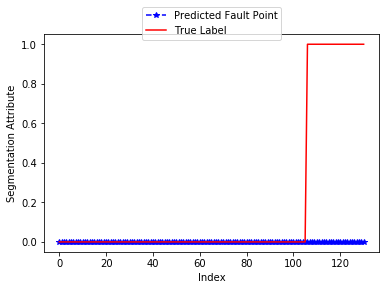

In [21]:
    for ep in range(1,epochs+1):
        now = time.strftime("%y%m%d_%H%M")    
        filepath='tmp/lstm_weights_%s.hdf5' %(now,)
        #filepath='tmp/cnn_weights_%s.hdf5' %(now,)
        checkpointer = ModelCheckpoint(filepath, 
                                       verbose=1, save_best_only=True)
        #model.load_weights('tmp/lstm_weights_171223_2003.hdf5')   
        
        f = open('tmp/column_min.txt_%s'%(now,),'w')   
        f.write(str(column_min))  
        f.close() 
        f = open('tmp/column_max.txt_%s' %(now,),'w')  
        f.write(str(column_max))  
        f.close() 
        
        print('epoch=',ep)
        model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        nb_epoch=1,
        validation_split=0.02,
        callbacks=[checkpointer])
        
        cost, accuracy = model.evaluate(X_test, y_test, batch_size=y_test.shape[0], verbose=False)
        print('test cost: ', cost, 'test accuracy: ', accuracy)
        y_pred = model.predict(X_test)
        
        y_pred_int = np.zeros(y_pred.shape, dtype = int)
        for i in range(y_pred.shape[0]):
            if y_pred[i][0] < y_pred[i][1]:
                y_pred_int[i][1] = 1
            else:
                y_pred_int[i][0] = 1
        print("[acc, pre, rec, F1] is:")
        print(metrics4(y_test,y_pred_int))
       
        y_pred_int = np.zeros(y_pred.shape[0], dtype = int)
        fault_pred = np.zeros(y_pred.shape[0], dtype = int)
        for i in range(y_pred.shape[0]):
            if y_pred[i][1] > 0.55:
                y_pred_int[i] = 1
        
        # 40 for about 5mins
        span = 40 * 3
        seuil = 0.9
        for k in range(span-1,y_pred.shape[0]-1,1):         
            if (sum(y_pred_int[k-span+1:k+1]) > seuil*span): 
                fault_pred[k] = 1

        print('Training duration (s) : ', time.time() - global_start_time)
        
#         plot_results(edg, y_test[:,1],ep)
        plt.clf()
        fig = plt.figure(facecolor='white')
        ax = fig.add_subplot(111)
        ax.plot(fault_pred,'b*--', label = 'Predicted Fault Point')
        ax.plot(y_test[:,1],'r',label='True Label')
        box=ax.get_position()
        ax.set_position(box)
        plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.15))
        plt.xlabel('Index')
        plt.ylabel('Segmentation Attribute')
        plt.show()

In [ ]:
#读入本地数据,将模型的输出批量写入到数据库中
from influxdb import DataFrameClient
from influxdb import InfluxDBClient
from train_model import *
from keras.models import load_model

def get_origin_data(num):
    df=pd.read_csv('data/'+num+'_data.csv',sep=',') 
    df['wman_state'] = df['wman_state'].map(conv2Noneflag)
       
    look_back = 1
    sweep= 1
    df = add_delta_tmp(df, 3000)
    
    df_sel = df.dropna()
    y_data = df_sel.loc[:,'wtur_flt_main'].values # 'wtur_flt_main' 不可加方括号
    time = df_sel.loc[:,'time'].values
    
    df_sel = df_sel.loc[:,["wind_speed",
        "generator_speed","power","wind_direction",
        "wind_direction_mean",
        "yaw_position",
        "pitch1_angle","pitch2_angle","pitch3_angle", 
        "environment_tmp","int_tmp",
        "acc_x","acc_y",
        "pitch1_ng5_tmp","pitch2_ng5_tmp","pitch3_ng5_tmp",
        "pitch1_moto_tmp","pitch2_moto_tmp","pitch3_moto_tmp",
        'tmp_3000'
        ]]
        
    norm_df = df_sel.iloc[:,:].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    
    x_data = norm_df.iloc[:,:].values
    
    dataX, dataY = convert_dataset(x_data, y_data, look_back, sweep)
    dataY = np_utils.to_categorical(dataY)
    
    print("=== get_origin_data ===")
    print("dimensions data are:")
    print(dataX.shape)
    print(dataY.shape)
    print(time.shape)
    return [time, dataX, dataY]

db = 'windturbine'
client = InfluxDBClient('166.111.38.226', 8086, 'bigdata', '1dW58Qbh4SQX', db )

[time, dataX, dataY] = get_origin_data('15_sample')
y_pred = model.predict(dataX)
y_pred_int = np.zeros(y_pred.shape[0], dtype = int)
fault_pred = np.zeros(y_pred.shape[0], dtype = int)
for i in range(y_pred.shape[0]):
    if y_pred[i][1] > 0.55:
        y_pred_int[i] = 1

# 40 for about 5mins
span = 40 * 3
seuil = 0.9
for k in range(span-1,y_pred.shape[0]-1,1):         
    if (sum(y_pred_int[k-span+1:k+1]) > seuil*span): 
        fault_pred[k] = 1
                
json_body = []
for i in range(dataX.shape[0]):
    json_body.append(
    {
        "measurement": "diagnose_test1",
        "tags": {
            "turbine": '150015'
        },
        "time": time[i],
        "fields": {
            "fault_prob": y_pred[i,1],
            "fault_point": y_pred_int[i],
            "if_alert": fault_pred[i],
        }
    }
        )
    if i % 10000 == 0:
        client.write_points(json_body)
        json_body = []

In [ ]:
# 部分实验记录

选取了少部分特征,LSTM结果:    
dimensions of traing data and test data are:
(43758, 1, 12)
(43758, 2)
(18754, 1, 12)
(18754, 2)

epoch= 1
Train on 42882 samples, validate on 876 samples
Epoch 1/1
42860/42882 [============================>.] - ETA: 0s - loss: 0.5433 - acc: 0.7200Epoch 00000: val_loss improved from inf to 1.01708, saving model to tmp/lstm_weights_171227_2328.hdf5
42882/42882 [==============================] - 44s - loss: 0.5432 - acc: 0.7201 - val_loss: 1.0171 - val_acc: 0.0422
test cost:  0.465486556292 test accuracy:  0.784845709801
        
[acc, pre, rec, F1] is:
[0.78484589954143114, 0.73717861515440075, 0.98446725406485602, 0.84306328030803934]

epoch= 2
Train on 42882 samples, validate on 876 samples
Epoch 1/1
42880/42882 [============================>.] - ETA: 0s - loss: 0.3973 - acc: 0.8202Epoch 00000: val_loss improved from inf to 0.65245, saving model to tmp/lstm_weights_171227_2334.hdf5
42882/42882 [==============================] - 42s - loss: 0.3973 - acc: 0.8202 - val_loss: 0.6525 - val_acc: 0.5731
test cost:  0.626719236374 test accuracy:  0.607816874981

        
CNN结果,很差
epoch= 1
Train on 42882 samples, validate on 876 samples
Epoch 1/1
42800/42882 [============================>.] - ETA: 0s - loss: 0.2121 - acc: 0.9154Epoch 00000: val_loss improved from inf to 0.24143, saving model to tmp/cnn_weights_171227_2341.hdf5
42882/42882 [==============================] - 23s - loss: 0.2120 - acc: 0.9155 - val_loss: 0.2414 - val_acc: 0.9589
test cost:  1.66097414494 test accuracy:  0.442892074585

In [ ]:
> Loading data... 
=== get_data_v0 ===
dimensions of traing data and test data are:
(19733, 60, 26)
(19733, 2)
(8457, 60, 26)
(8457, 2)

******LSTM 减少了正常样本的比例后：
> Data Loaded. Compiling...
> Compilation Time :  0.02680683135986328
epoch= 1
Train on 19338 samples, validate on 395 samples
Epoch 1/1
19330/19338 [============================>.] - ETA: 0s - loss: 0.3849 - acc: 0.8139Epoch 00000: val_loss improved from inf to 0.89694, saving model to tmp/lstm_weights_171225_1952.hdf5
19338/19338 [==============================] - 262s - loss: 0.3848 - acc: 0.8139 - val_loss: 0.8969 - val_acc: 0.3392
test cost:  1.65724658966 test accuracy:  0.517795860767
edge:
[453, 833, 3790, 5526, 6419, 7919]
预测的聚类中心个数：6
Training duration (s) :  333.05648970603943

    [acc, pre, rec, F1] is:
[0.51779590871467418, 0.59496051147047757, 0.62185534591194969, 0.60811070536229095]

epoch= 2
Train on 19338 samples, validate on 395 samples
Epoch 1/1
19330/19338 [============================>.] - ETA: 0s - loss: 0.2474 - acc: 0.8957Epoch 00000: val_loss improved from inf to 0.90058, saving model to tmp/lstm_weights_171225_2004.hdf5
19338/19338 [==============================] - 252s - loss: 0.2473 - acc: 0.8957 - val_loss: 0.9006 - val_acc: 0.5519
test cost:  2.02002573013 test accuracy:  0.42532813549
edge:
[957, 1450, 3790, 5380, 5527, 5647, 6037, 6419, 7937]
预测的聚类中心个数：9
Training duration (s) :  1013.2155096530914

epoch= 3
Train on 19338 samples, validate on 395 samples
Epoch 1/1
19330/19338 [============================>.] - ETA: 0s - loss: 0.1615 - acc: 0.9370Epoch 00000: val_loss improved from inf to 1.80654, saving model to tmp/lstm_weights_171225_2009.hdf5
19338/19338 [==============================] - 255s - loss: 0.1615 - acc: 0.9371 - val_loss: 1.8065 - val_acc: 0.2000
test cost:  1.97060227394 test accuracy:  0.475818872452
edge:
[832, 3429, 3790, 5348, 6060, 6419, 7970]
[acc, pre, rec, F1] is:
[0.47581884829135629, 0.56535621632408706, 0.55680031446540879, 0.56104564808396873]
*****过拟合？

In [ ]:
*****减少了正常样本的比例后 CNN：
dimensions of traing data and test data are:
(19733,1, 60, 26)
(19733, 2)
(8457, 1,60, 26)
(8457, 2)

epoch= 1
Train on 19338 samples, validate on 395 samples
Epoch 1/1
19320/19338 [============================>.] - ETA: 0s - loss: 0.4416 - acc: 0.7831Epoch 00000: val_loss improved from inf to 1.07892, saving model to tmp/cnn_weights_171225_2018.hdf5
19338/19338 [==============================] - 21s - loss: 0.4414 - acc: 0.7832 - val_loss: 1.0789 - val_acc: 0.3696
test cost:  0.616311848164 test accuracy:  0.635449826717
edge:
[829, 3171, 3790, 4741, 5148, 5525, 6419, 7908]
预测的聚类中心个数：8
[acc, pre, rec, F1] is:
[0.63544992314059356, 0.7547649301143583, 0.58372641509433965, 0.65831763271639143]

epoch= 2
Train on 19338 samples, validate on 395 samples
Epoch 1/1
19330/19338 [============================>.] - ETA: 0s - loss: 0.3053 - acc: 0.8627Epoch 00000: val_loss improved from inf to 0.81911, saving model to tmp/cnn_weights_171225_2020.hdf5
19338/19338 [==============================] - 21s - loss: 0.3053 - acc: 0.8627 - val_loss: 0.8191 - val_acc: 0.5266
test cost:  0.609837651253 test accuracy:  0.639351904392
edge:
[941, 1072, 1430, 3790, 4502, 4759, 5148, 5955, 6419, 7919]
预测的聚类中心个数：10

epoch= 3
Train on 19338 samples, validate on 395 samples
Epoch 1/1
19280/19338 [============================>.] - ETA: 0s - loss: 0.2550 - acc: 0.8874Epoch 00000: val_loss improved from inf to 0.67219, saving model to tmp/cnn_weights_171225_2021.hdf5
19338/19338 [==============================] - 20s - loss: 0.2551 - acc: 0.8873 - val_loss: 0.6722 - val_acc: 0.5418
test cost:  0.578714430332 test accuracy:  0.577627956867
edge:
[831, 1425, 3790, 5148, 5957, 6419, 7930]

[acc, pre, rec, F1] is:
[0.57762800047298102, 0.72762762762762767, 0.47621855345911951, 0.57567118080304114]

看起来模型很容易就过拟合了

### 采用v0法获取数据，LSTM一次训练结果
<br>Loading data... </br>
<br>=== get_data_v0 ===</br>
<br>dimensions of traing data and test data are:</br>
(65233, 1, 26)
(65233, 2)
(27958, 1, 26)
(27958, 2)
<br>Data Loaded. Compiling...</br>
<br>Compilation Time :  0.014130115509033203</br>
<br>epoch= 1</br>
<br>Train on 63928 samples, validate on 1305 samples</br>
<br>Epoch 1/1</br>
<br>63850/63928 [============================>.] - ETA: 0s - loss: 0.4888 - acc: 0.7655Epoch 00000: val_loss improved from inf to 0.83057, saving model to tmp/lstm_weights_171224_2237.hdf5</br>
<br>63928/63928 [==============================] - 31s - loss: 0.4888 - acc: 0.7654 - val_loss: 0.8306 - val_acc: 0.2498</br>
<br>**test cost:  0.369300633669 test accuracy:  0.844194889069**</br>
edge:</br>
[6792, 7523, 7875, 12754, 15740, 15950, 21161, 21702, 23158, 25177, 26339, 26827]
预测的聚类中心个数：12</br>
Training duration (s) :  55.188950061798096</br>
![](tmp/lstm1.png)
图上很宽的方波应该是邻近故障聚合的结果！每一个蓝星代表着一大段故障点的第一个。需要两大段故障点之间相隔100个点，才会被认为是两段故障。

[acc, pre, rec, F1] is:
[0.84419486372415764, 0.75967129234824404, 0.88638625056535503, 0.8181514569591718]


### 采用v1法获取数据，CNN一次训练结果
<br>=== get_data_v1 ===</br>
(29328, 1, 60, 13)
(29328, 2)
(12570, 1, 60, 13)
(12570, 2)
<br>epoch= 1</br>
Train on 28741 samples, validate on 587 samples</br>
<br>Epoch 1/1</br>
<br>28720/28741 [============================>.] - ETA: 0s - loss: 0.3216 - acc: 0.8620Epoch 00000: val_loss improved from inf to 0.63528, saving model to tmp/cnn_weights_171224_2316.hdf5</br>
<br>28741/28741 [==============================] - 53s - loss: 0.3215 - acc: 0.8620 - val_loss: 0.6353 - val_acc: 0.5843</br>
<br>**test cost:  0.84616535902 test accuracy:  0.720047712326**</br>
<br>edge:</br>
[851, 1282, 1729, 4616, 5016, 5173, 5383, 5703, 7415, 7629, 8906, 9532, 11946]</br>
<br>预测的聚类中心个数：13</br>
![](tmp/cnn1.png)

[acc, pre, rec, F1] is:
[0.72004773269689737, 0.6284591452431636, 0.75432389937106914, 0.6856632425189817]

### 采用get_data_sub法获取数据，lstm一次训练结果
Train on 31934 samples, validate on 652 samples
Epoch 1/1
31930/31934 [============================>.] - ETA: 0s - loss: 0.3302 - acc: 0.8635Epoch 00000: val_loss improved from inf to 0.40050, saving model to tmp/lstm_weights_171225_1042.hdf5
31934/31934 [==============================] - 497s - loss: 0.3301 - acc: 0.8635 - val_loss: 0.4005 - val_acc: 0.7761
<br>***test cost:  0.690901458263 test accuracy:  0.678166747093***<br/>
edge:
[642, 798, 921, 1281, 1415, 1869, 2388, 3726, 4602, 4730, 6119, 6819, 10282, 10853, 13153, 13449]
预测的聚类中心个数：16
![](tmp/get_data_sub_lstm1.png)

### 采用get_data_sub法获取数据，lstm两次训练结果
epoch= 1
Train on 31934 samples, validate on 652 samples
Epoch 1/1
31930/31934 [============================>.] - ETA: 0s - loss: 0.1823 - acc: 0.9346Epoch 00000: val_loss improved from inf to 2.11612, saving model to tmp/lstm_weights_171225_1059.hdf5
31934/31934 [==============================] - 496s - loss: 0.1822 - acc: 0.9346 - val_loss: 2.1161 - val_acc: 0.1472
test cost:  0.741073668003 test accuracy:  0.705833375454